In [16]:
import NetDes
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

<b style="font-size:30px;">Step1:</b>

<p style="font-size:20px; line-height:2;">Load the dataframe with one column containing pseudotime from "testdatatime.csv".

Load the scRNA-seq gene expression data from 'testexpression.csv'; it is preferable if the dataset has more than 10,000 columns.

Load the initial Gene Regulatory Network (GRN) from 'Initial_network.csv'.</p>

In [17]:
pseudo=pd.read_csv("testdatatime.csv") # load pseudotime
tf12=pd.read_csv('testexpression.csv') # load smoothed data
network1=pd.read_csv('Initial_network.csv')# load initial GRN
#net1_restrictions=pd.read_csv('network1_interlist.csv') # load the interaction you want keep in the GRN
names=tf12.iloc[:, 0] # obtain gene names
tf12.index = [names] #set rownames
cellnames = list(tf12.columns) 
cellnames2=cellnames[1:]#obtain cell names
pseudo['cellnames']=cellnames2 # assign the cell name to a
gene_list = pd.unique(network1['Target'])# get the gene in two list, everygene just exist once


In [18]:
network1.columns = ['Source', 'Target', 'Interaction']

<b style="font-size:30px;">Step2: </b>

<p style="font-size:20px; line-height:2;">Next, process the data by assigning the column containing pseudotime to pseudotime_col.</p>

In [19]:
pseudotime, tf12pickcell,cellpick = NetDes.selectcell(pseudo, tf12,pseudotime_col=0)
tf12expression,tf12expression_logtarget, pseudotime_pick = NetDes.process_tf(tf12, tf12pickcell, pseudo, cellpick,pseudotime_col=0)

<b style="font-size:30px;">Step3:</b>

<p style="font-size:20px; line-height:2;">For the first round of optimization, the default setting calculates all sample initial parameters. To speed up the process, you can add pick=0.1, which will calculate only 10% of the initial parameters.</p>

In [20]:
random.seed(1)
#First stage
Part1=NetDes.MSE_stPoint(gene_list=gene_list,network=network1,
                  expression=tf12expression,log_expression=tf12expression_logtarget)


gene2
gene1
gene3


<b style="font-size:30px;">Step 4: </b>

<p style="font-size:20px; line-height:2;">In the second round of optimization, resample the initial parameters from the top-performing initial parameters.</p>

In [21]:
Part2= NetDes.MSE_top(gene_list=gene_list,network=network1,
               expression=tf12expression,log_expression=tf12expression_logtarget,MSE_table=Part1)


gene2
gene1
gene3


<b style="font-size:30px;">Step 5:</b>

<p style="font-size:20px; line-height:2;">Calculate the fitting results for different deletions. Based on these results, choose the best deletion.</p>

In [22]:
w_tot=NetDes.tuning(MSE_table2=Part2,nums=20,gene_list=gene_list) # Optimize with tuning parameters
Part3=NetDes.MSE_bin(MSE_table2=Part2,w_tot=w_tot,gene_list=gene_list,
              network=network1,expression=tf12expression,log_expression=tf12expression_logtarget)# Identify removable edges
consis_results=NetDes.consis_test(gene_list=gene_list,MSE_table=Part3)
int_test=NetDes.interactions_test(gene_list=gene_list,network=network1,
                           consis=consis_results,MSE_table=Part3,expression=tf12expression,log_expression=tf12expression_logtarget,tolerance=[-0.01,0.99])


gene2
gene1
gene3
gene2
gene1
gene3


<b style="font-size:30px;">Step 6:</b>

<p style="font-size:15px;">Display how the network size changes as the cutoff value varies.</p>

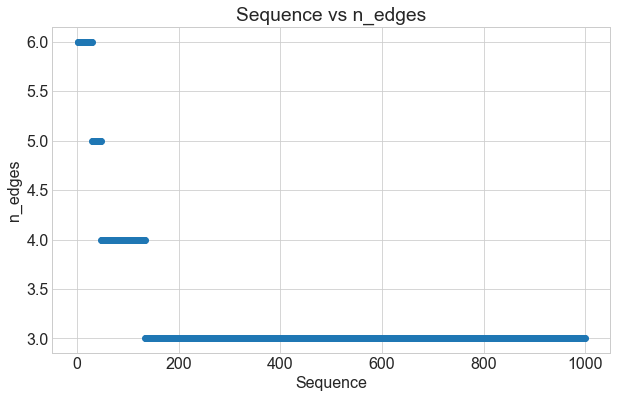

In [23]:
lines_MSEcut_df = NetDes.plot_sequence_vs_edges(gene_list=gene_list, network=network1,start=1, stop=1000, step=1, int_results=int_test, consis_res=consis_results, plot_type='scatter')

You can choose the total number of network edges you want by setting cut_value as follows or just use cut_value =30 :

In [24]:
# cut_value = lines_MSEcut_df[lines_MSEcut_df['n_edges'] == 5]['Sequence']

<b style="font-size:30px;">Step 7: </b>

<p style="font-size:20px; line-height:2;">Calculate the network parameters and save the results. The parameters will be stored in res_final, and the network structure will be saved in combined_network.</p>

In [25]:

del_results=NetDes.delete_int(gene_list=gene_list,network=network1,int_results=int_test,consis_res=consis_results,MSE_cut=30)
Part4=NetDes.MSE_delete_fitting(gene_list=gene_list,network=network1,expression=tf12expression,log_expression=tf12expression_logtarget,del_int=del_results)
w_tot_2=NetDes.tuning(MSE_table2=Part4,nums=20,gene_list=gene_list)
res_final=NetDes.parameter_fitting(MSE_del_table=Part4,w_tot=w_tot_2,gene_list=gene_list,del_int=del_results,network=network1,expression=tf12expression,log_expression=tf12expression_logtarget)
ob_newall=Part4[1].copy()
res_final=res_final[0]
combined_network = NetDes.save_combined_network(gene_list, ob_newall, res_final,output="test.csv")


gene2
gene1
gene3
gene2
['gene1', 'gene4']
gene1
['gene2', 'gene3']
gene3
['gene2']


<p style="font-size:20px; line-height:2;">You can view the fitting results based on these parameters. </p>

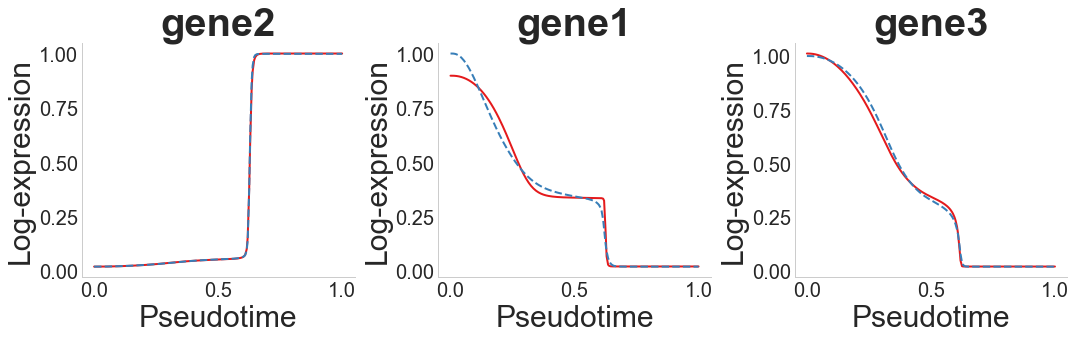

In [26]:
NetDes.plot_network_results(
    gene_list=gene_list,
    network=network1,
    tfexpression=tf12expression,
    ob_newall=ob_newall,
    res_final=res_final,
    tfexpression_logtarget=tf12expression_logtarget,
    pseudotime_pick=pseudotime_pick
)

plt.savefig('fitting1.pdf', format='pdf', bbox_inches='tight')

<b style="font-size:30px;">Step 8: </b>

<p style="font-size:20px; line-height:2;">Process the data to drive the system using the parameters of this network.</p>

In [27]:
tf12expression_logtarget2, tf12expression_target2, gene_position,gene_list2 = NetDes.process_gene_expression(tf12expression_logtarget, 
                                                                           tf12expression, 
                                                                           gene_list, 
                                                                           ob_newall)

ob_newall2, res_final2,gene_position2=NetDes.Fit_withoutinput(gene_list=gene_list2,
                                                              res_final=res_final,ob_newall=ob_newall,gene_position=gene_position,tfexpression_logtarget=tf12expression_logtarget)

gene4


<p style="font-size:20px; line-height:2;">The results for the two genes driving the system are as follows: df_2lines shows the gene expression differences with the forward driving results, while df_2lines_dif displays the difference between the forward and backward driving results.</p>

In [28]:
drivers = pd.unique(combined_network['Source']) 
df_2lines, df_2lines_dif=NetDes.two_gene_driving(dt=1,t_tot=5000,gene_list=gene_list2,drivers=drivers,tfexpression_target2=tf12expression_target2,res_final=res_final2,gene_position=gene_position2,
                 tfexpression=tf12expression,ob_all=ob_newall2,network=network1)
               

gene2
gene1
0.00
gene2
gene3
0.17
gene2
gene4
0.33
gene1
gene3
0.50
gene1
gene4
0.67
gene3
gene4
0.83


<p style="font-size:20px; line-height:2;">The results for the one gene driving the system are as follows: df shows the gene expression differences with the forward driving results, while df_dif displays the difference between the forward and backward driving results.</p>

In [29]:
df, df_dif =NetDes.one_gene_driving(dt=0.1,t_tot=500,gene_list= gene_list2, drivers=drivers,
                             tfexpression_target2=tf12expression_target2,res_final=res_final2,
                              gene_position=gene_position2,network=network1, 
                              tfexpression=tf12expression, ob_all=ob_newall2)


gene2
gene1
gene3
gene4


<p style="font-size:20px; line-height:2;">You can view the driving performance by specifying the gene names in dri_genes.</p>

Processing single gene: gene4


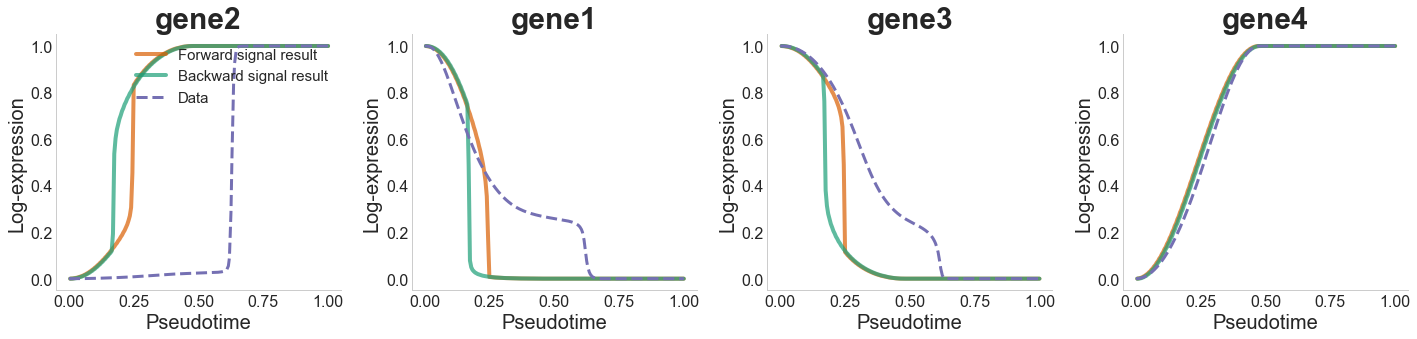

In [30]:

cache={}
df3, df4,cache,figs = NetDes.driving_results(
    dri_genes=["gene4"],
    gene_list=gene_list2,
    tfexpression_target2=tf12expression_target2,
    network=network1,
    tfexpression=tf12expression,
    pseudotime_pick=pseudotime_pick,
    res_final=res_final2,
    ob_newall=ob_newall2,
    gene_position=gene_position2,
    cached=False,
    cache=cache# Enable caching for faster subsequent runs
)

figs.savefig('driving_results_figure_6inGRN_gene4.pdf', dpi=300, bbox_inches='tight')